## TODO:
* when eta is high, the battery will charge and discharge more often. This leads to alot of dots in the 2nd figure. 
* run code for 2 setups with high (realistic) and low eta

In [1]:
%load_ext autoreload
%autoreload 2
from tools import EnergyStorageModel

In [2]:
import numpy as np
# how do align 

## ETA HIGH

In [62]:
# Example Usage:
model = EnergyStorageModel(eta_charge=0.98, 
                           eta_discharge=0.97, 
                           beta = 0.99,
                           a_bar = 1,
                           num_storage_levels=10,
                           num_actions=25,
                           num_price_levels=50,
                           tolerance = 1e-2,
                           max_iteration=10_000,
                           simulate_prices = True,
                           mean_reversion= 0.3,
                           p_variance = 100,
                           risk_averse=False,
                           risk_parameter=0.005)

Simulating price series...


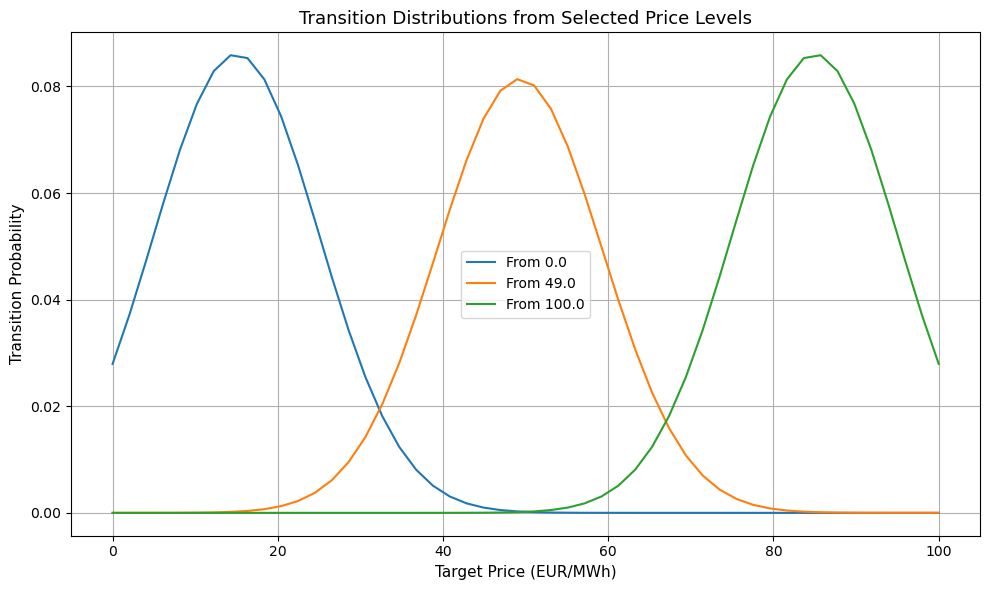

In [63]:
model.plot_price_transition_distributions()


In [64]:
V, P = model.vfi_vec() 

Starting Value Function Iteration...
Converged in 626 iterations.


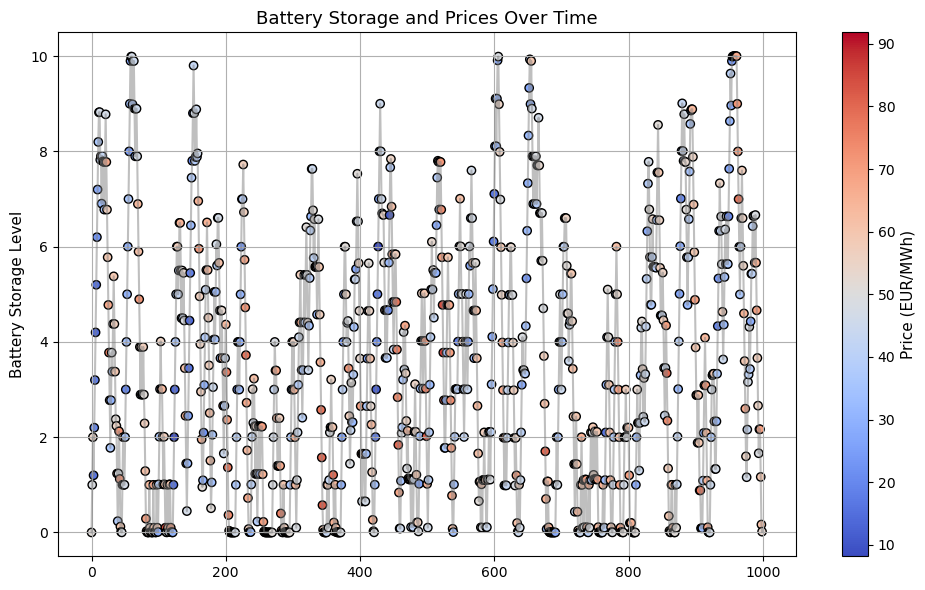

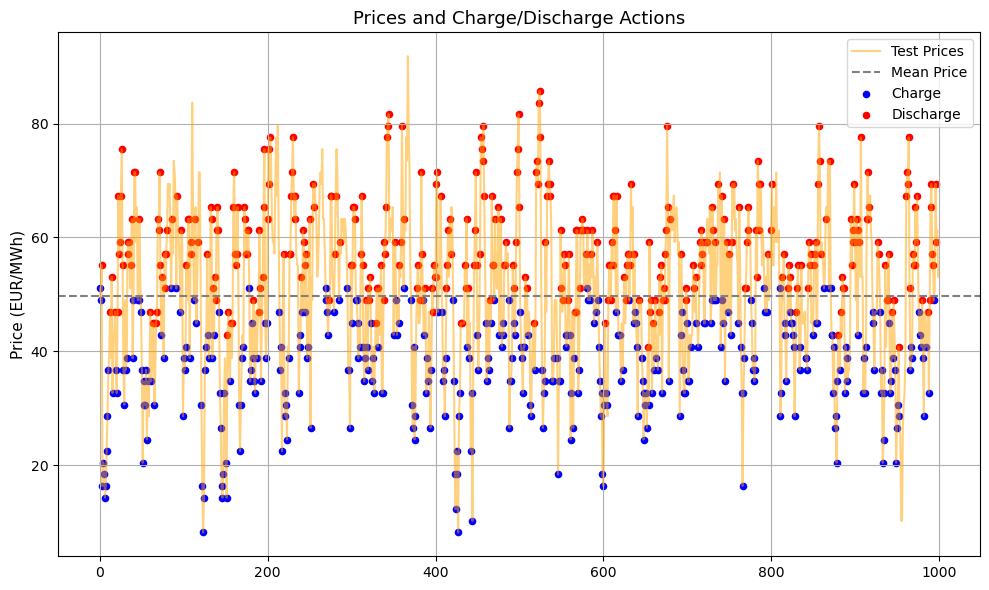

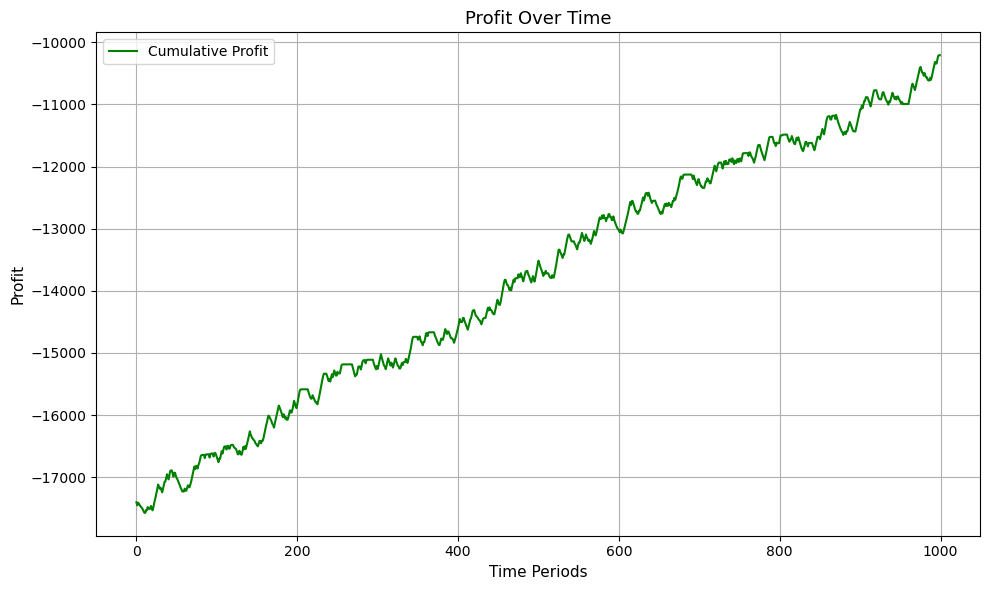

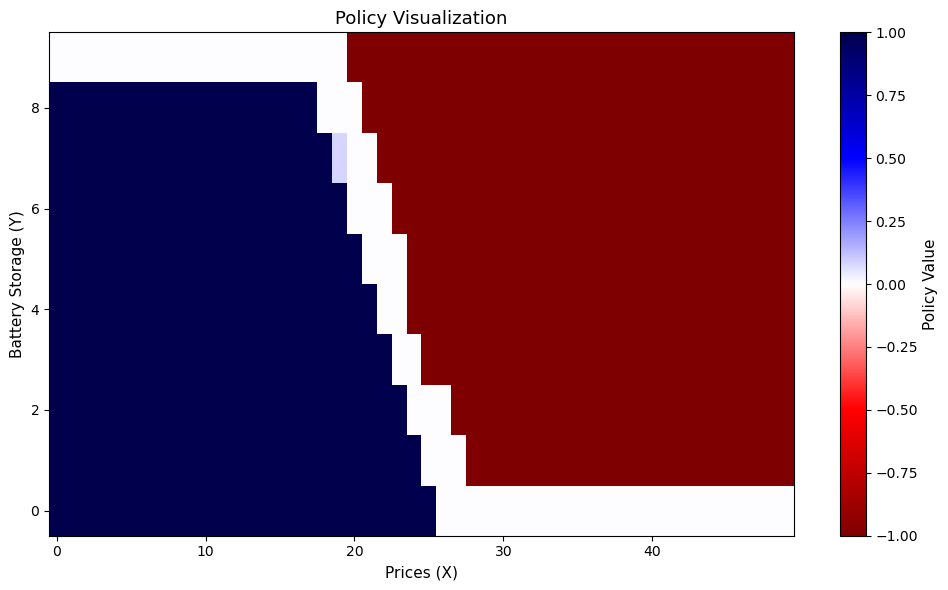

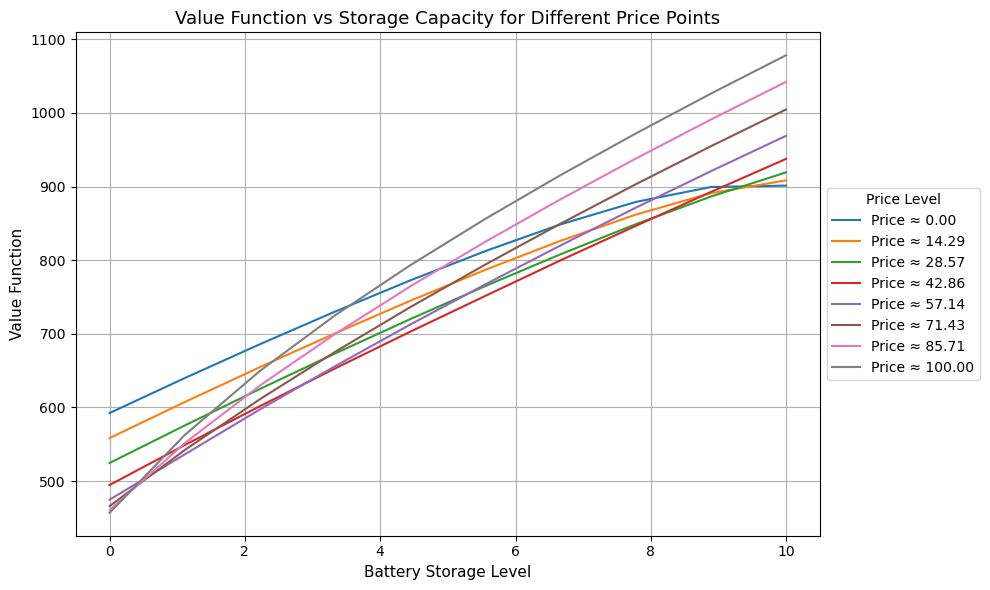

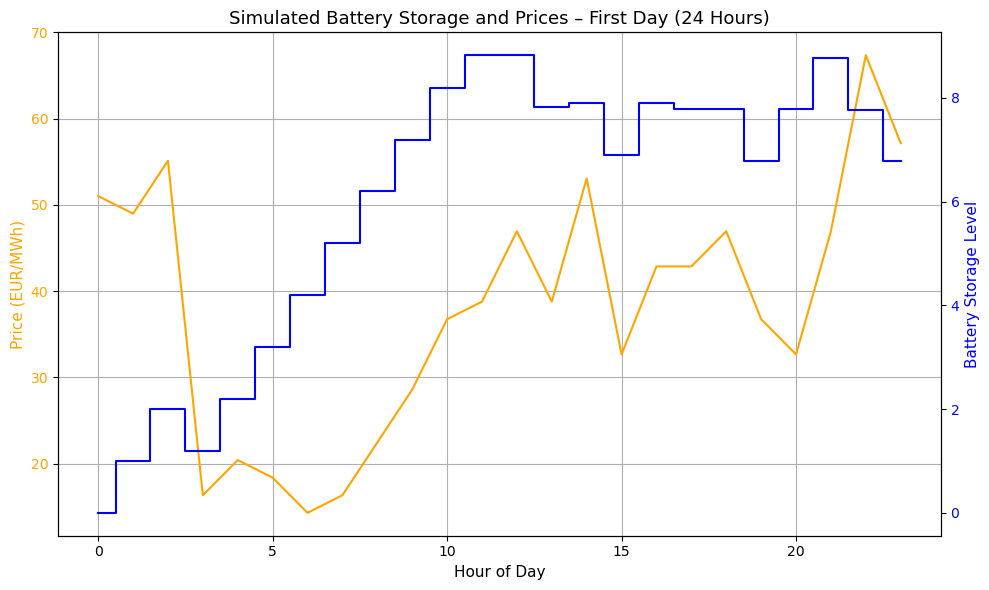

In [65]:
battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)
model.plot_results(battery_storage_sim, profit_sim, action_sim)

In [7]:
# loop over 
from collections import defaultdict

# Create a 3D dictionary (using defaultdict)
tech_policy = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

# Initialize your parameters
N = 5
eta_chart = np.linspace(0.8, 1, N)
eta_discharge = np.linspace(0.8, 1, N)
sigma = np.linspace(0.1/100/24, 0.01, N)

# Loop over all combinations of eta_charge, eta_discharge, and sigma
for i in range(N):
    for j in range(N):
        for k in range(N):
            print(f"eta_charge: {eta_chart[i]}, eta_discharge: {eta_discharge[j]}, sigma: {sigma[k]}")
            
            # Assign values to model parameters
            model.eta_charge = eta_chart[i]
            model.eta_discharge = eta_discharge[j]
            model.sigma = sigma[k]
            
            # Call model's method to calculate policy (V, P)
            V, P = model.vfi_vec()

            battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)
            
            # Store the policy (P) in the 3D dictionary with (eta_charge, eta_discharge, sigma) as keys
            tech_policy[eta_chart[i]][eta_discharge[j]][sigma[k]] = profit_sim[-1] #


eta_charge: 0.8, eta_discharge: 0.8, sigma: 4.1666666666666665e-05
Starting Value Function Iteration...
Converged in 592 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.00253125
Starting Value Function Iteration...
Converged in 104 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.005020833333333333
Starting Value Function Iteration...
Converged in 93 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.007510416666666666
Starting Value Function Iteration...
Converged in 76 iterations.
eta_charge: 0.8, eta_discharge: 0.8, sigma: 0.01
Starting Value Function Iteration...
Converged in 61 iterations.
eta_charge: 0.8, eta_discharge: 0.8500000000000001, sigma: 4.1666666666666665e-05
Starting Value Function Iteration...
Converged in 379 iterations.
eta_charge: 0.8, eta_discharge: 0.8500000000000001, sigma: 0.00253125
Starting Value Function Iteration...
Converged in 16 iterations.
eta_charge: 0.8, eta_discharge: 0.8500000000000001, sigma: 0.005020833333333333
Starting 

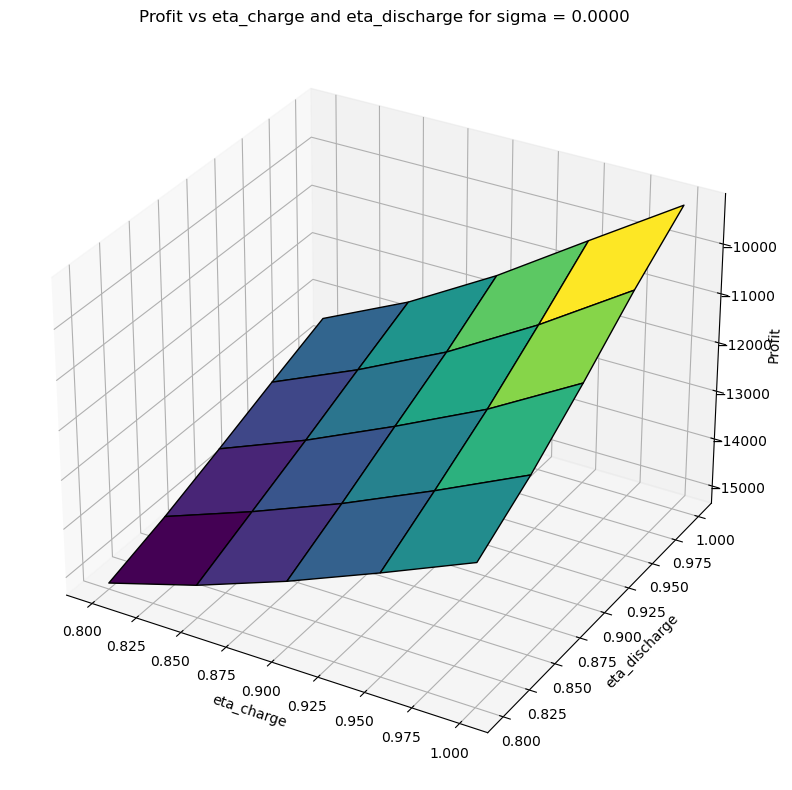

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# Select a specific sigma value (e.g., 3rd sigma)
selected_sigma = sigma[0]

# Create meshgrid for eta_charge and eta_discharge
eta_grid, discharge_grid = np.meshgrid(eta_chart, eta_discharge)

# Gather profit values for the selected sigma
z_values = np.array([[tech_policy[eta_chart[i]][eta_discharge[j]][selected_sigma] 
                      for j in range(N)] for i in range(N)])

# 3D plot setup
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(eta_grid, discharge_grid, z_values, cmap='viridis', edgecolor='k')

# Labeling
ax.set_xlabel('eta_charge')
ax.set_ylabel('eta_discharge')
ax.set_zlabel('Profit')
ax.set_title(f'Profit vs eta_charge and eta_discharge for sigma = {selected_sigma:.4f}')

plt.tight_layout()
plt.show()


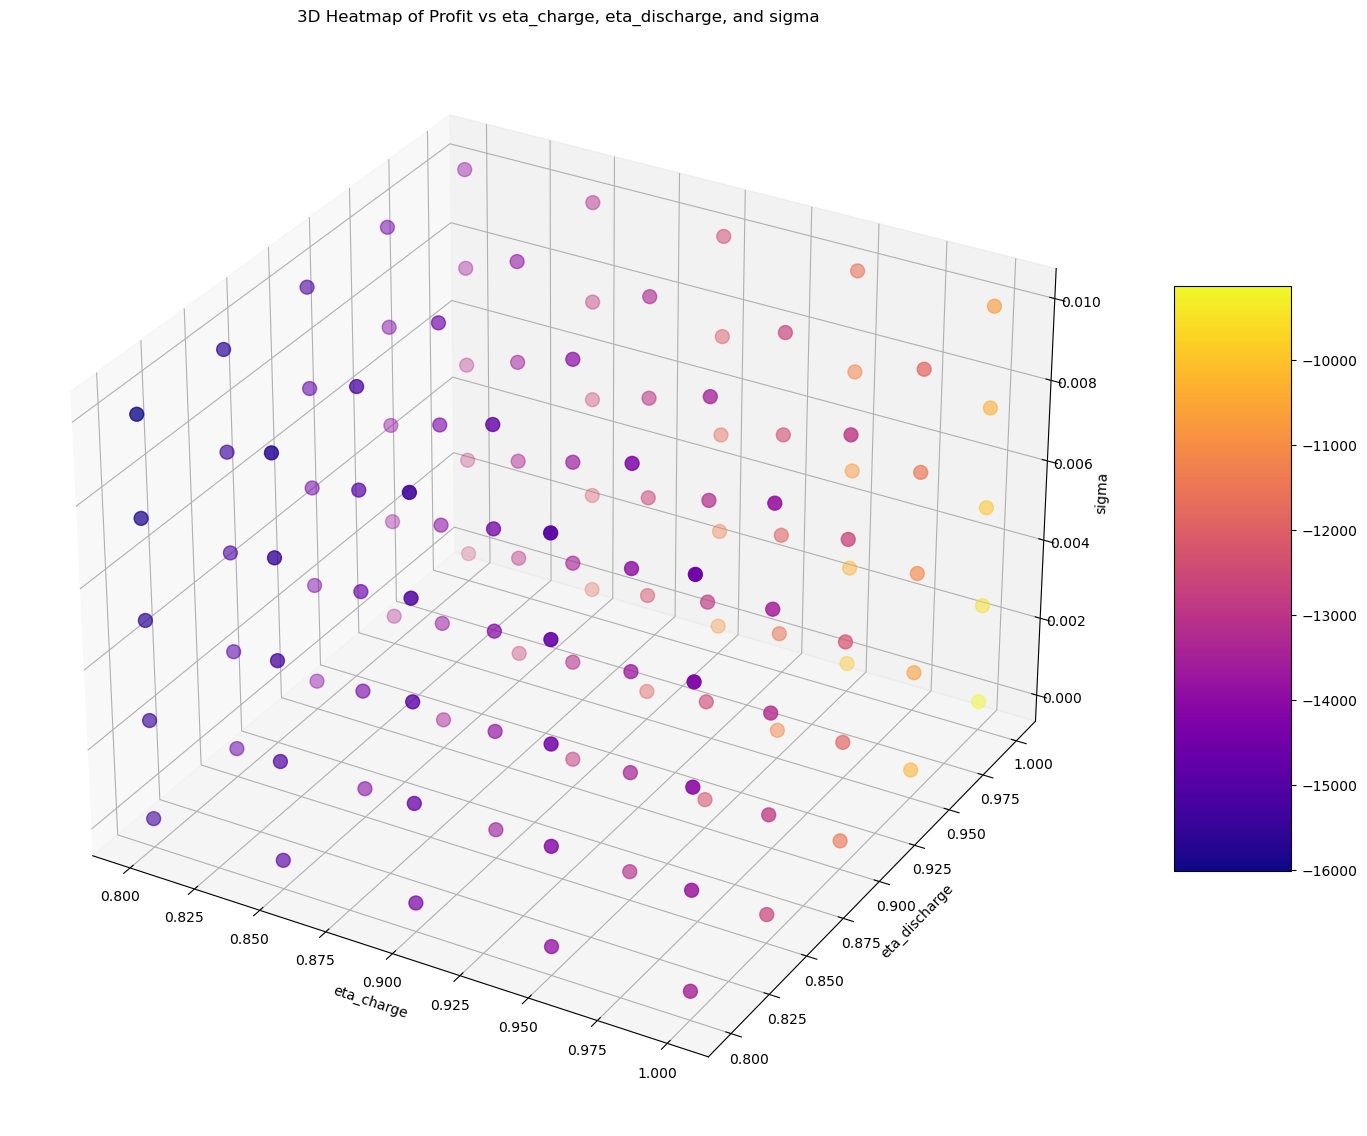

In [9]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors

# Create meshgrid for eta_charge, eta_discharge, and sigma
eta_grid, discharge_grid, sigma_grid = np.meshgrid(eta_chart, eta_discharge, sigma)

# Flatten the grids for easier plotting
eta_flat = eta_grid.flatten()
discharge_flat = discharge_grid.flatten()
sigma_flat = sigma_grid.flatten()

# Gather the corresponding profit values from tech_policy
z_values = np.array([tech_policy[eta_flat[i]][discharge_flat[i]][sigma_flat[i]] 
                     for i in range(len(eta_flat))])

# 3D plot setup
fig = plt.figure(figsize=(14, 12))  # Increase figure size further for clarity
ax = fig.add_subplot(111, projection='3d')

# Normalize the z-values for better contrast, focusing on the extremes
norm = mcolors.Normalize(vmin=z_values.min(), vmax=z_values.max())

# Scatter plot with even larger points and a high contrast colormap
scatter = ax.scatter(eta_flat, discharge_flat, sigma_flat, c=z_values, cmap='plasma', marker='o', s=100, norm=norm)

# Labeling
ax.set_xlabel('eta_charge')
ax.set_ylabel('eta_discharge')
ax.set_zlabel('sigma')
ax.set_title('3D Heatmap of Profit vs eta_charge, eta_discharge, and sigma')

# Add color bar with normalized range for more contrast
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5)

plt.tight_layout()
plt.show()



--- Running Model with risk_averse = False ---
Simulating price series...
Starting Value Function Iteration...
Converged in 626 iterations.

--- Running Model with risk_averse = True ---
Simulating price series...
Starting Value Function Iteration...
Converged in 458 iterations.

--- Summary Comparison ---
Risk-Neutral: Final Cumulative Profit = -10948.90
Risk-Averse: Final Cumulative Profit = -13374.46


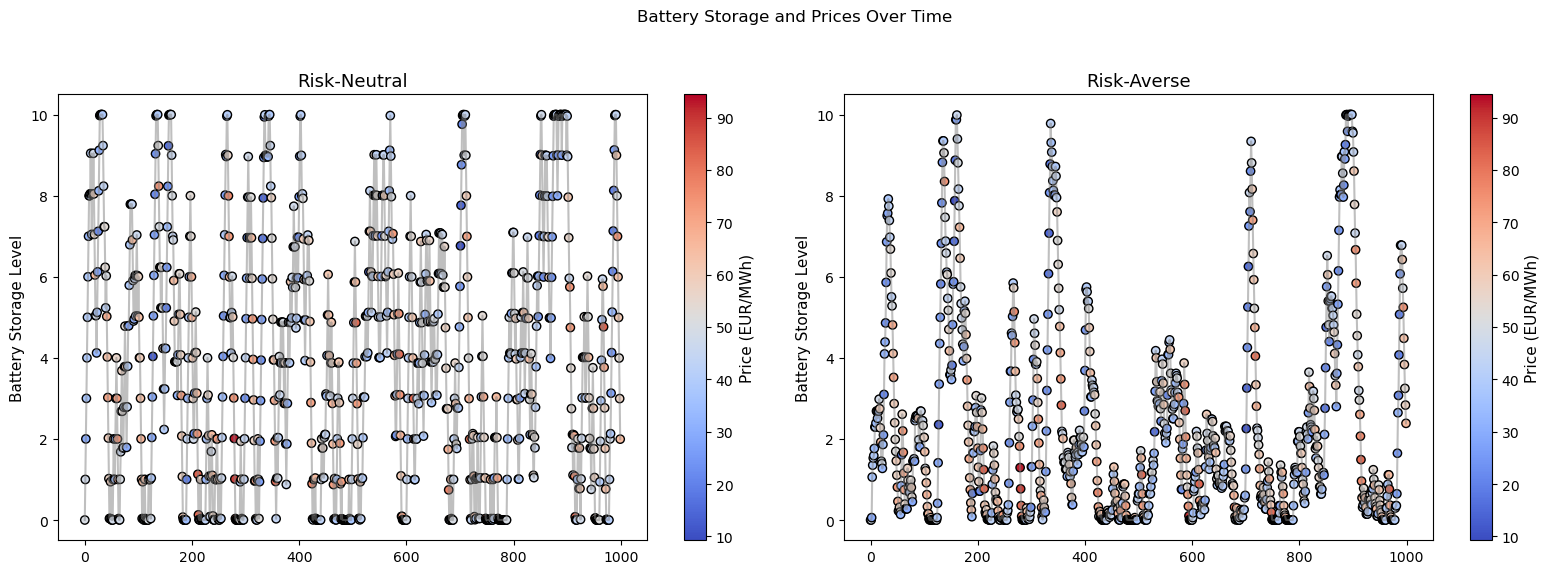

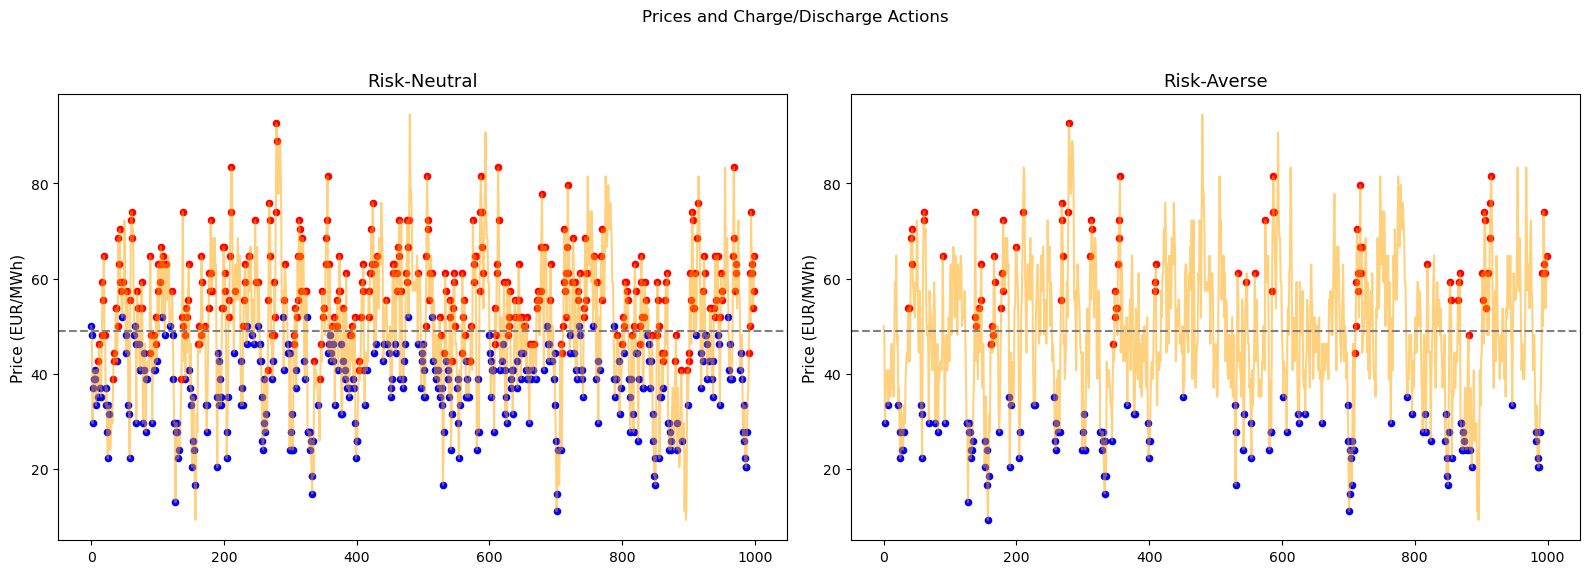

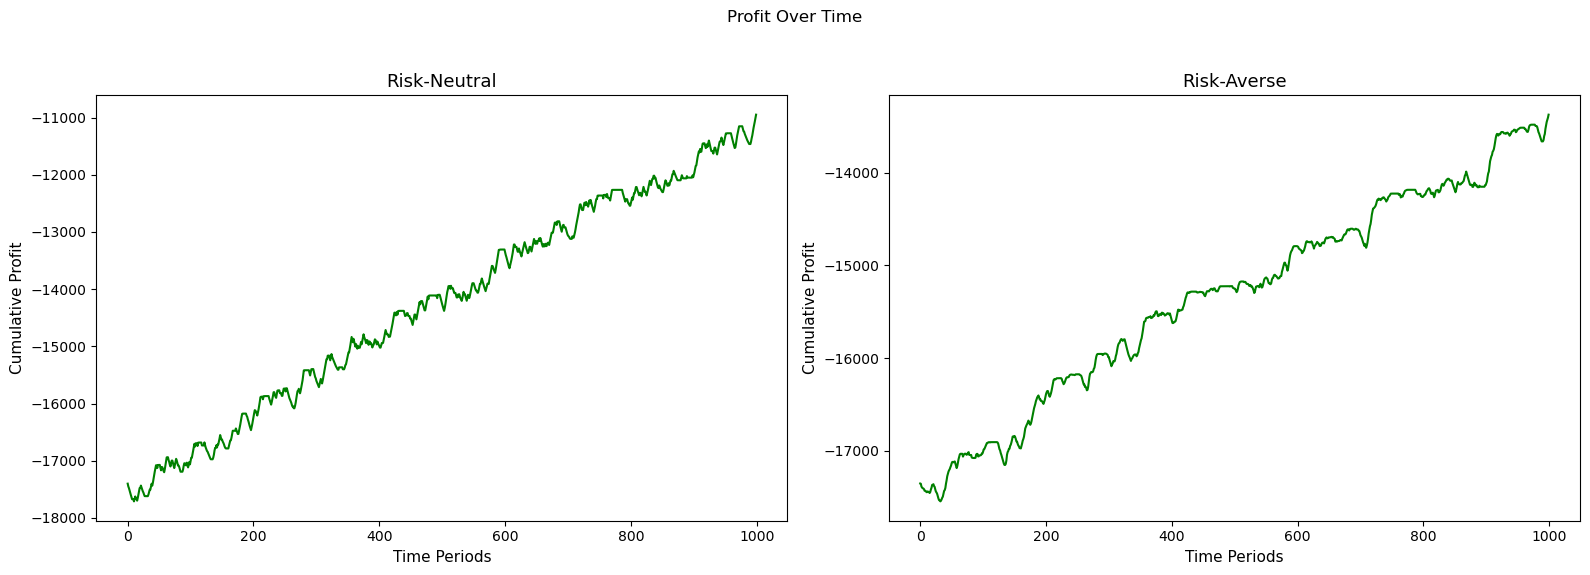

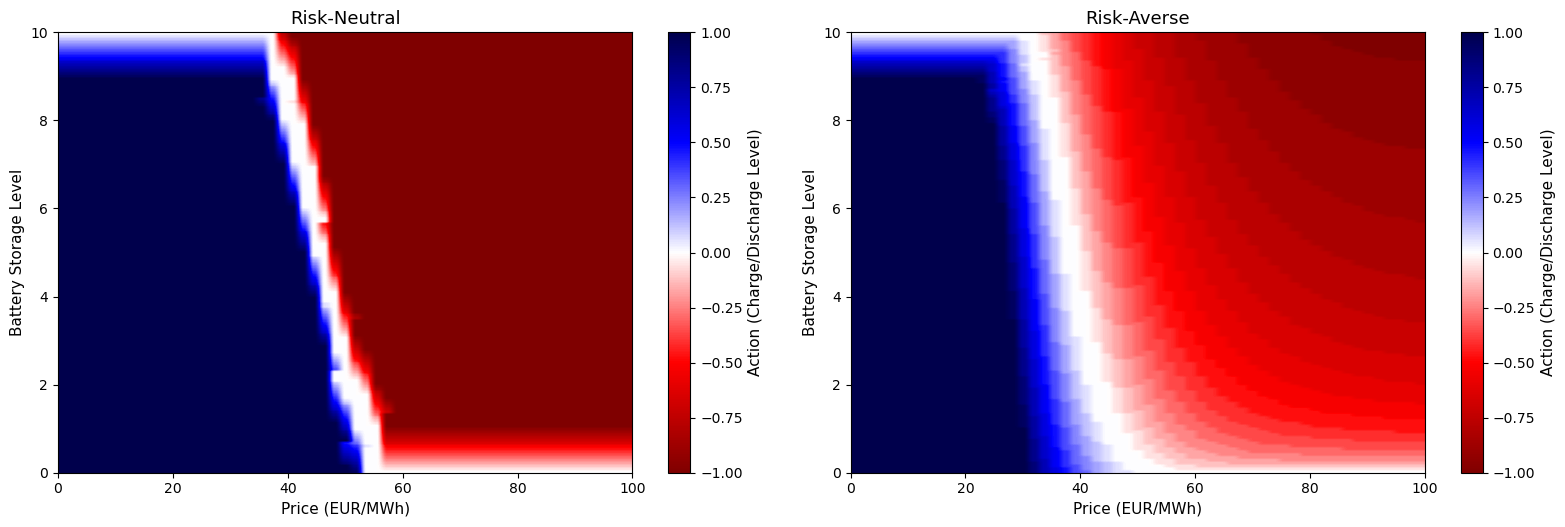

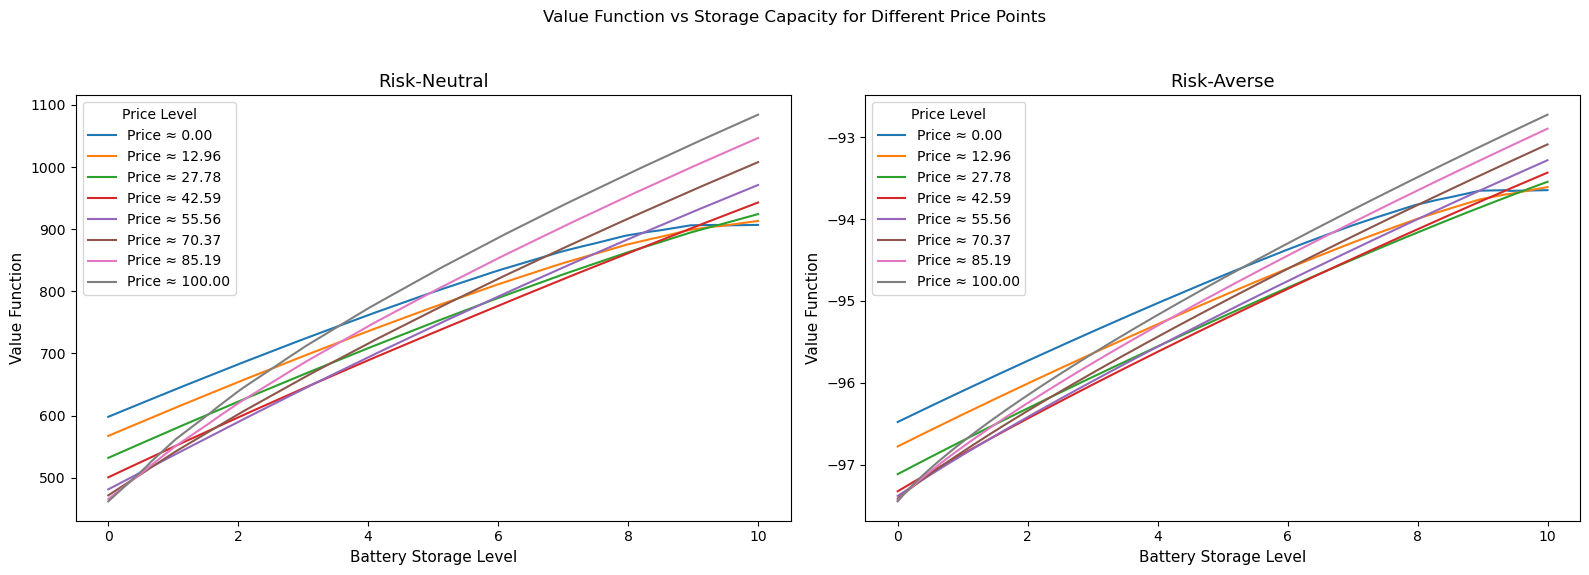

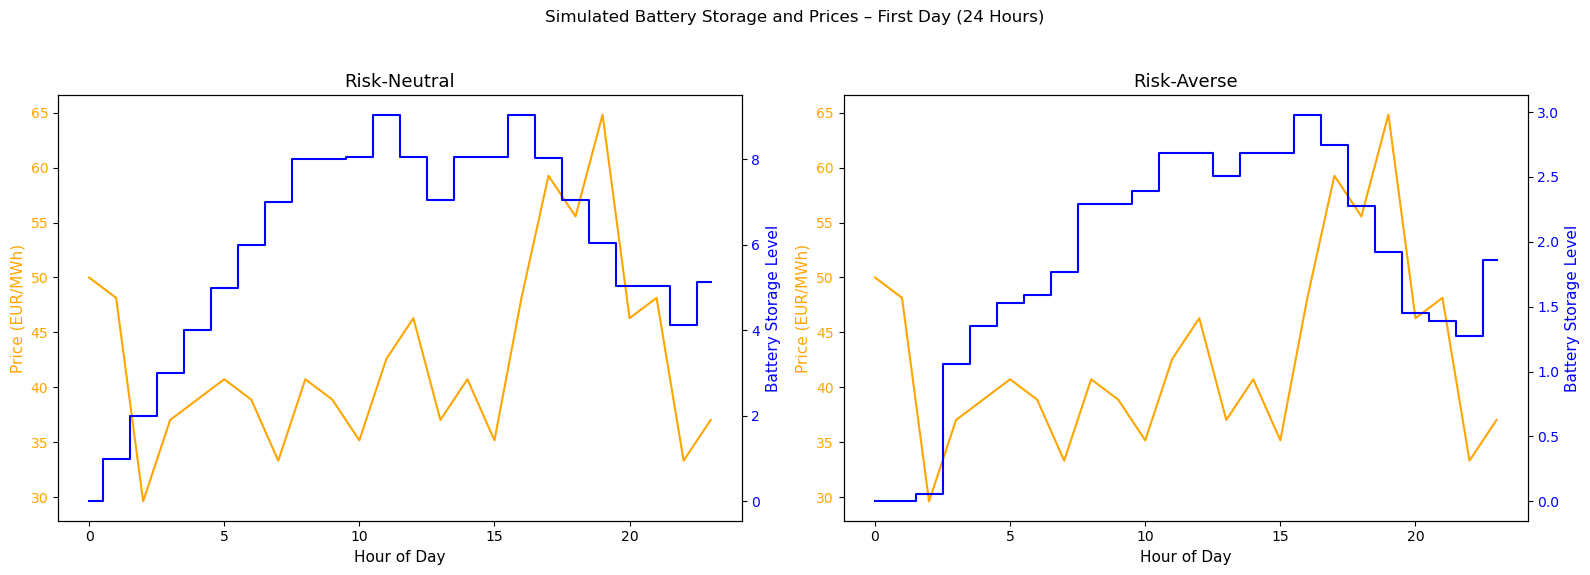

In [56]:
# Define results storage
results = {}

# Loop over both risk settings
for risk_setting in [False, True]:
    print(f"\n--- Running Model with risk_averse = {risk_setting} ---")

    # Initialize the model
    model = EnergyStorageModel(
        eta_charge=0.98,
        eta_discharge=0.97,
        beta=0.99,
        a_bar=1,
        num_storage_levels=155,
        num_actions=35,
        num_price_levels=55,
        tolerance=1e-2,
        max_iteration=10_000,
        simulate_prices=True,
        mean_reversion=0.3,
        p_variance=100,
        risk_averse=risk_setting,
        risk_parameter=0.01  # Only used when risk_averse=True
    )

    # Solve value function and get policy
    V, P = model.vfi_vec()

    # Simulate using the policy
    battery_storage_sim, profit_sim, action_sim = model.simulate(policy=P)

    # Store results
    results[risk_setting] = {
        'model': model,
        'V': V,
        'policy': P,
        'storage': battery_storage_sim,
        'profit': profit_sim,
        'action': action_sim
    }

    # Plot simulation results
    #model.plot_results(battery_storage_sim, profit_sim, action_sim)

# Compare key statistics after loop
print("\n--- Summary Comparison ---")
for setting, res in results.items():
    final_profit = res['profit'][-1]  # Take cumulative profit at final period
    label = "Risk-Averse" if setting else "Risk-Neutral"
    print(f"{label}: Final Cumulative Profit = {final_profit:.2f}")

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_results_comparison(results):
    labels = {False: "Risk-Neutral", True: "Risk-Averse"}
    cmap = plt.get_cmap("seismic_r")

    for plot_name in [
        "Battery Storage and Prices Over Time",
        "Prices and Charge/Discharge Actions",
        "Profit Over Time",
        "",
        "Value Function vs Storage Capacity for Different Price Points",
        "Simulated Battery Storage and Prices – First Day (24 Hours)"
    ]:
        fig, axs = plt.subplots(1, 2, figsize=(16, 6))
        fig.suptitle(plot_name)

        for i, risk_setting in enumerate([False, True]):
            model = results[risk_setting]['model']
            storage = results[risk_setting]['storage']
            profit = results[risk_setting]['profit']
            action = results[risk_setting]['action']
            ax = axs[i]
            ax.set_title(labels[risk_setting])

            if plot_name == "Battery Storage and Prices Over Time":
                sc = ax.scatter(range(len(storage)), storage, c=model.prices_test, cmap="coolwarm", edgecolors="k")
                ax.plot(storage, linestyle="-", alpha=0.5, color="gray")
                ax.set_ylabel("Battery Storage Level")
                fig.colorbar(sc, ax=ax, label="Price (EUR/MWh)")

            elif plot_name == "Prices and Charge/Discharge Actions":
                ax.plot(model.prices_test, color="orange", alpha=0.5)
                ax.axhline(np.mean(model.prices_test), color='gray', linestyle='--')
                ax.scatter(np.where(action > model.a_bar - 0.5)[0], model.prices_test[action > model.a_bar - 0.5], color="blue", s=20)
                ax.scatter(np.where(action < -model.a_bar + 0.5)[0], model.prices_test[action < -model.a_bar + 0.5], color="red", s=20)
                ax.set_ylabel("Price (EUR/MWh)")

            elif plot_name == "Profit Over Time":
                ax.plot(profit, color="green")
                ax.set_xlabel("Time Periods")
                ax.set_ylabel("Cumulative Profit")
            elif plot_name == "":
                policy = model.policy
                price_vals = model.price_grid
                storage_vals = model.battery_grid

                non_zero = policy != 0
                norm = mcolors.TwoSlopeNorm(
                    vmin=policy[non_zero].min(),
                    vcenter=0,
                    vmax=policy[non_zero].max()
                )

                im = ax.imshow(
                    policy,
                    origin='lower',
                    aspect='auto',
                    cmap=cmap,
                    norm=norm,
                    extent=[price_vals[0], price_vals[-1], storage_vals[0], storage_vals[-1]]
                )

                fig.colorbar(im, ax=ax, label="Action (Charge/Discharge Level)")
                ax.set_xlabel("Price (EUR/MWh)")
                ax.set_ylabel("Battery Storage Level")


            elif plot_name == "Value Function vs Storage Capacity for Different Price Points":
                selected_price_indices = np.linspace(0, model.num_price_levels - 1, 8, dtype=int)
                for idx in selected_price_indices:
                    price_level = model.price_grid[idx]
                    ax.plot(model.battery_grid, model.V[:, idx], label=f'Price ≈ {price_level:.2f}')
                ax.set_xlabel('Battery Storage Level')
                ax.set_ylabel('Value Function')
                ax.legend(title="Price Level")

            elif plot_name == "Simulated Battery Storage and Prices – First Day (24 Hours)":
                hours = np.arange(24)
                ax2 = ax.twinx()
                ax.plot(hours, model.prices_test[:24], color='orange')
                ax.set_ylabel('Price (EUR/MWh)', color='orange')
                ax.tick_params(axis='y', labelcolor='orange')
                ax2.step(hours, storage[:24], color='blue', where='mid')
                ax2.set_ylabel('Battery Storage Level', color='blue')
                ax2.tick_params(axis='y', labelcolor='blue')
                ax.set_xlabel('Hour of Day')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

plot_results_comparison(results)



/var/folders/t0/s501t6qj4s771m9zd789h6pr0000gn/T/ipykernel_44892/1848260314.py:67: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


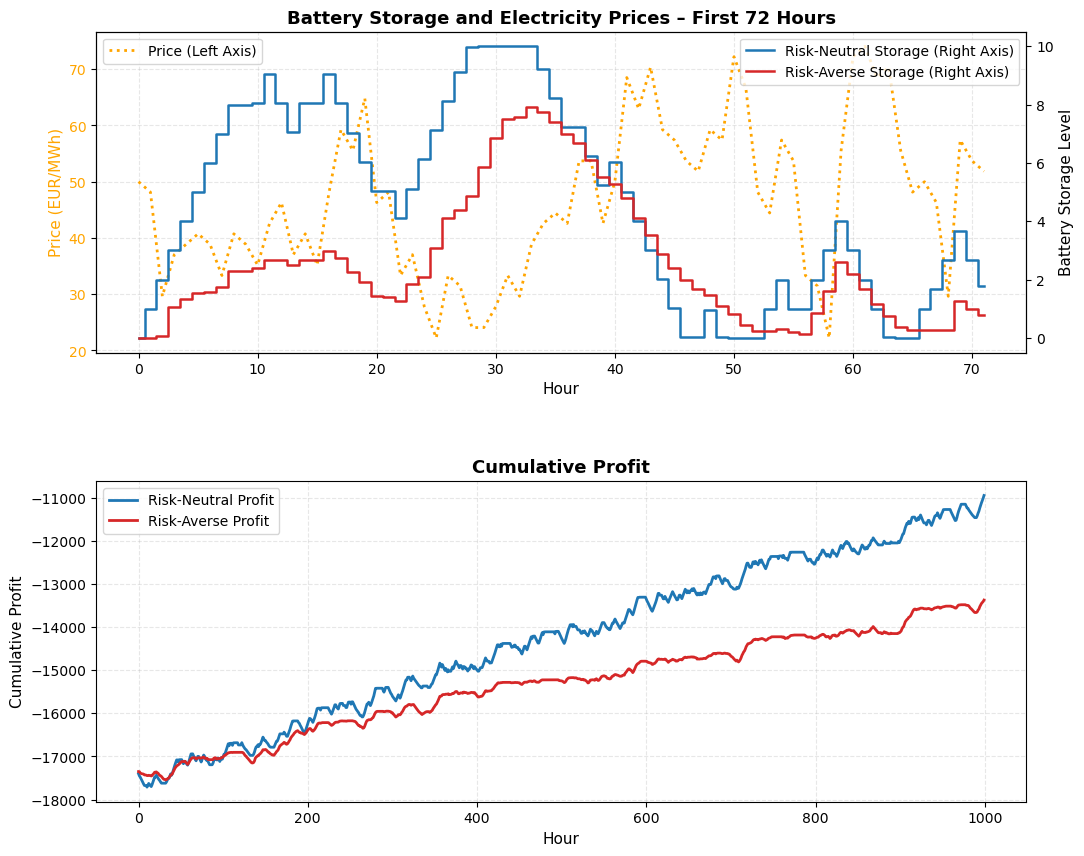

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Define labels and colors
labels = {False: "Risk-Neutral", True: "Risk-Averse"}
colors = {False: "#1f77b4", True: "#d62728"}  # Blue, Red

plt.rcParams.update({
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'legend.fontsize': 10,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

# --- Create two aligned subplots ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=False, gridspec_kw={'hspace': 0.4})

# --- Top Plot: Battery Storage and Prices (72 Hours) ---
ax1b = ax1.twinx()
hours = np.arange(72)
prices = results[False]['model'].prices_test[:72]
line_price, = ax1.plot(
    hours, prices, linestyle=":", color="orange", linewidth=2,
    label="Price (Left Axis)"
)
ax1.set_ylabel("Price (EUR/MWh)", color="orange")
ax1.tick_params(axis='y', labelcolor="orange")
ax1.set_xlabel("Hour")

# Storage on right y-axis
storage_lines = []
for risk_setting in [False, True]:
    storage = results[risk_setting]['storage'][:72]
    line, = ax1b.step(
        hours, storage, where='mid',
        label=f"{labels[risk_setting]} Storage (Right Axis)",
        color=colors[risk_setting], linewidth=1.8
    )
    storage_lines.append(line)

ax1b.set_ylabel("Battery Storage Level", color="black")
ax1b.tick_params(axis='y', labelcolor="black")
ax1.set_title("Battery Storage and Electricity Prices – First 72 Hours", fontweight='bold')

# Add separate legends
ax1.legend([line_price], ["Price (Left Axis)"], loc="upper left")
ax1b.legend(storage_lines, [l.get_label() for l in storage_lines], loc="upper right")

ax1.grid(True, linestyle="--", alpha=0.3)

# --- Bottom Plot: Cumulative Profit Over Full Simulation ---
time = np.arange(len(results[False]['profit']))
for risk_setting in [False, True]:
    profit = results[risk_setting]['profit']
    ax2.plot(
        time, profit,
        label=f"{labels[risk_setting]} Profit",
        color=colors[risk_setting], linewidth=2
    )
ax2.set_title("Cumulative Profit", fontweight='bold')
ax2.set_xlabel("Hour")
ax2.set_ylabel("Cumulative Profit")
ax2.legend()
ax2.grid(True, linestyle="--", alpha=0.3)

plt.tight_layout()
plt.show()


## ETA LO

In [ ]:
model_2 = EnergyStorageModel(price_data_path='../data/entsoe_price_DK_1_20150101_20240101.csv',
                             eta_charge=0.85,
                             eta_discharge=0.85,
                             num_actions=13)
model_2.compute_price_transitions()
V2, P2 = model_2.value_function_iteration()
battery_storage_sim, profit_sim = model_2.simulate()
model_2.plot_results(battery_storage_sim, profit_sim)
